# So you've got your robot arm - what now?

This notebook is designed to get you up and running with some first movements on your robot arm. It will introduce you to the various modes of control in the arm's API, including cartesian and joint control, position and velocity control, inverse kinematics, simulation in MuJoCo, and screw trajectories. This is a condensed version of how I got up to speed on the fundmentals of robot arms, specifically on my Ufactory Lite 6.

It is based on some of the topics covered in the MuJoCo least squares notebook: https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/least_squares.ipynb#scrollTo=jXuA25sJydAy

Some other great resources you should check out afterwards:
- https://roboticseabass.com/2024/06/30/how-do-robot-manipulators-move/
- https://hades.mech.northwestern.edu/index.php/Modern_Robotics
- https://github.com/kevinzakka/mjctrl
- https://github.com/kevinzakka/mink
- https://github.com/huggingface/lerobot

# Setup
## MuJoCo Model
- For this demo I'm using a UFactory Lite 6 arm. You should be able to follow along with another arm if you're able to adapt the model XML and their Python API.
- The robot arm model in MuJoCo is specified by an XML file. It also comes 3D mesh files (used to define the appearance of the robot parts) in the `assets` folder. 
- The assets are in the mujoco_menagerie repository. git clone mujoco_menagerie into the root directory. TODO: add link
- models/lite6_viz.xml is an edited version of the lite6 model from mujoco_menagerie. Change the meshdir in line 2 to point to the `assets` folder of the corresponding model in mujoco_menagerie. 
  - If you're using a different model, a "target" body is added to visualise the target frame, and a site is added to the target and the attachemnt point. If you're not using the ufactory arm you'll have to add these changes yourself - they're commented in the model I've provided here. There is also some lighting and a floor added but these are optional.


## Dependencies
- Use conda (or a venv) to install packages:
```
conda create -n mujoco_2_real python=3.10 jupyter
conda activate mujoco_2_real
jupyter notebook
```
- Open the jupyter link in your browser and view the notebook

In [1]:
! pip install mujoco numpy numpy-quaternion mediapy pathlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
  Using cached numpy-2.0.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached mediapy-1.2.2-py3-none-any.whl.metadata (4.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached glfw-2.7.0-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38-none-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached PyOpenGL-3.1.7-py3-none-any.whl.metadata (3.2 kB)
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pillow-10.4.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached zipp-3.19.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached contourpy-1.2.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using c

In [2]:
import mujoco
from mujoco import minimize
import numpy as np
import mediapy as media
from pathlib import Path
import quaternion
np.set_printoptions(precision=4, suppress=True, linewidth=100)


Load the mujoco model first
These high level data structures are the most important:
- model: the model loaded from the XML/MJCF file, and any static information that goes with it
- data: the current state of the model, any variables that change throughout the simulatino, e.g. current sim time, joint positions and velocities, collisions
- renderer: renders an image of the scene

In [3]:
# Load model XML
model_path = "models/lite6_viz.xml"
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

To progress the simulation, use:
- mj_step: steps the simulation forward in time - calculates forces, friction, collisions, controls - for a realisic simulation

In order to set up the scene, calculate any parameters that don't require the full calculation, or avoid constraints:
- mj_forward: computes the forward dynamics, but does not step it forward in time. Useful for setting up a scene
- mj_kinematics: computes forward kinematics (i.e. joint positions), but does not recalculate any forces, dynamics, sensors or lighting

More here: https://mujoco.readthedocs.io/en/stable/APIreference/APIfunctions.html#main-simulation


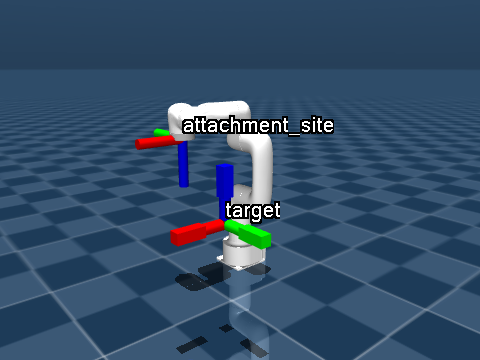

In [4]:
# Reset the model to the first keyframe defined in the XML. We could also refer to it by name
mujoco.mj_resetDataKeyframe(model, data, 0)
# Update the sim with the model's reset position
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.5
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)
camera.lookat = (0, 0, 0.3)

# Visualize site frames (the RGB axes) and labels (text)
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
voption.label = mujoco.mjtLabel.mjLABEL_SITE

# Call this after every physics step to update the renderer
renderer.update_scene(data, camera, voption)

# Unset this flag so future renders do not show site label text
voption.label = mujoco.mjtLabel.mjLABEL_NONE

media.show_image(renderer.render())


In [5]:
# Joint ranges if you're interested
print(f"Joint ranges:\n{model.jnt_range}")
bounds = [model.jnt_range[:, 0], model.jnt_range[:, 1]]

Joint ranges:
[[-6.2832  6.2832]
 [-2.618   2.618 ]
 [-0.0611  5.236 ]
 [-6.2832  6.2832]
 [-2.1642  2.1642]
 [-6.2832  6.2832]]


# Spin trajectory
Now we let's add some motion! Here we define a basic motion that just moves the arm in a circle whilst bobbing up and down

In [6]:
# Function for generating waypoints for test motions

def spin_motion(time, speed=1, init_quat=np.array((np.sqrt(2)/2, 0, np.sqrt(2)/2, 0))):
  """
  Generate waypoints for the following motion:
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the attachment facing outwards
  """

  pos = np.array((0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.35 + 0.1 * np.sin(3 * speed*time)))
  # Angle around z axis
  theta = np.arctan2(pos[1], pos[0])
  # Convert to quaternion
  quat = np.array((np.cos(theta/2), 0, 0, np.sin(theta/2)))
  quat /= np.linalg.norm(quat)

  res_quat = np.zeros(4)
  mujoco.mju_mulQuat(res_quat, quat, init_quat)

  return pos, res_quat


Let's visualise these waypoints using the 'target' frame defined in the XML. This has the mocap attribute set to true - a mocap ("motion capture") body does not participate in physics and is just used for visualisation.

In [7]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset the time to 0 and the robot pose to initial
mujoco.mj_resetData(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  pos, quat = spin_motion(data.time)
  id = model.body('target').mocapid
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

# Run the spinning motion in cartesian coordinates

The simplest way to get up and running with the real robot is to use its API to set the end effector pose in cartseian coordinates, without having to deal with inverse kinematics.
For the Xarm, this is provided by the `set_position` (orientation in euler angles) or `set_position_aa` (orientation in axis angle) functions. Unfortunately there is no quaternion interface. Because [euler angles are horrible](https://github.com/moble/quaternion/wiki/Euler-angles-are-horrible), we'll go with axis angle.

If you're not using the real robot, skip ahead to the Inverse Kinematics Primer.

## Utils
To do the conversion from quaternion to axis angle, metres to millimetres, and other little differences between MuJoCo and the Xarm API, here are some useful functions

In [8]:
def quaternion_to_axis_angle(quat):
  """
  Converts a quaternion to axis-angle representation.

  Args:
    quat: A 4-element quaternion (w, x, y, z) or np.quaternion.

  Returns:
    A tuple containing the axis (a 3-element vector) and the angle (in radians).
  """

  # Extract the scalar and vector components of the quaternion
  if isinstance(quat, np.quaternion):
    w = quat.w
    x = quat.x
    y = quat.y
    z = quat.z
  else:
    w = quat[0]
    x = quat[1]
    y = quat[2]
    z = quat[3]

  # Calculate the angle
  angle = 2 * np.arccos(w)

  # Calculate the axis
  if angle == 0:
    axis = np.array([0, 0, 0])  # Zero vector if angle is zero
  else:
    axis = np.array([x, y, z]) * angle / np.linalg.norm(np.array([x, y, z]))

  return axis

def mujoco_to_xarm_pose(pos, quat):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  pos_mm = np.array(pos)*1e3
  aang = quaternion_to_axis_angle(quat)
  return list(pos_mm) + list(aang)

def xarm_to_mujoco_pose(pos_aang):
  """
  Convert from xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az] to position (in m) and quaternion
  """
  angle = np.linalg.norm(pos_aang[3:])
  axis = pos_aang[3:]/angle

  quat = np.zeros(4)
  mujoco.mju_axisAngle2Quat(quat, axis, angle)

  pos = np.array(pos_aang)[:3]/1000.

  return pos, quat

# TESTS
# (these are not complete)

# Check that the conversion functions are legit by converting back and forth
pos, quat = spin_motion(0)
pose_xarm = mujoco_to_xarm_pose(pos, quat)
pos_recomp, quat_recomp = xarm_to_mujoco_pose(pose_xarm)
print(f"Orig: {pos}, {quat} should equal recomputed: {pos_recomp} {quat_recomp}")
print(f"Xarm axis angle: {pose_xarm}")

# ompare the np arrays
assert(np.allclose(pos, pos_recomp))
assert(np.allclose(quat, quat_recomp))
print("Success")


Orig: [0.   0.4  0.35], [ 0.5 -0.5  0.5  0.5] should equal recomputed: [0.   0.4  0.35] [ 0.5 -0.5  0.5  0.5]
Xarm axis angle: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]
Success


## Getting to the start position
The first challenge comes before even executing the spinning motion - we need to get to the starting pose.
The easiest way is to teleoperate the robot arm to roughly the right place so it doesn't self collide.

For this arm and this task, what also works well is just setting the joint angles.

Another approach is create a simple screw trajectory to get it there, which is demonstrated at the end of the notebook.



In [ ]:
from xarm.wrapper import XArmAPI
import time
import collections
ip = "192.168.1.185"
arm = XArmAPI(ip, is_radian=True)

Let's ask the arm its current position and visualise it in MuJoCo.
We'll then visualise the starting pose of the movement to see where need to get to


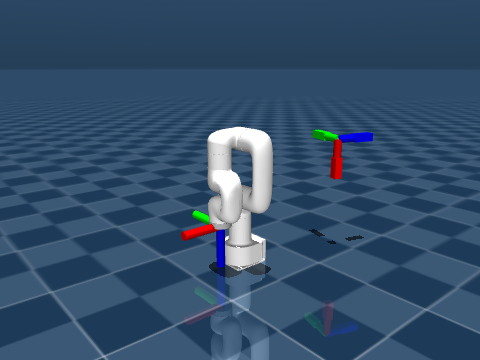


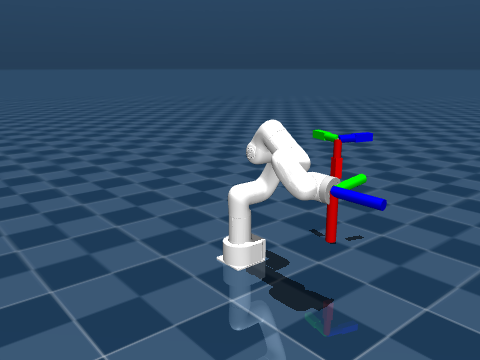

In [55]:
# Visualise current arm pose, and the new pose to get to

# Get the joint angles
code, state = arm.get_servo_angle()
if code:
  print(f"Invalid pos reading, codes: {(code)}") 

data.qpos = state[:6]
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption)
media.show_image(renderer.render())

data.qpos = model.key('faceout').qpos
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption)
media.show_image(renderer.render())


I've defined the starting joint angles for the motion in the model XML for convenience, as the 'faceout' keypose. We'll figure out how to calculate these in the next section about inverse kinematics.


Now, let's move the arm into position.
If you're scared of damaging your precious robot, feel free to turn the speed down.

The arm also needs to be set to "servo motion" (i.e. joint control) mode. Here's a list of the arm modes, from the API:
  
0. position control mode
1. servo motion mode
2. joint teaching mode
3. cartesian teaching mode (invalid)
4. joint velocity control mode
5. cartesian velocity control mode
6. joint online trajectory planning mode 
7. cartesian online trajectory planning mode 

In [ ]:
init_x = model.key('faceout').qpos
arm.set_state(state=0)
arm.set_mode(mode=1)
time.sleep(1)
arm.set_servo_angle(angle=init_x, speed=0.5, wait=True)
print("Ready")

If at any point the robot throws an error code/self intersects, use this to reset it. I also found it useful to have the GUI in the browser up to see/reset error codes. It's accessible at 192.168.55.1:6006 (your robot's IP address may be different).

In [ ]:
# Use this to reset any errors
arm.reset()

Now that we're at the start, let's spin!
Here's a loop that updates the position at a rate of 5 Hz. There's some code to time the loop at the target rate, and a printout of the actual rate achieved.
The speed of the spinning motion can be scaled using the `speed` argument of `spin_motion`. For now we'll keep it at a stately 0.2.

In [ ]:
DURATION = 30
RATE = 5

timing_print_interval = 0.5
t = 0
# A buffer to record the timing readings and average them out
buff_len = int(RATE * print_interval)
tdiff = collections.deque(maxlen=buff_len)

# Position control mode
arm.set_mode(mode=0)
time.sleep(1)

start_time = time.time()

while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print the rate every 0.5s to make sure we're keeping up
    if (len(tdiff) > 0) and int(t/timing_print_interval) != int(t_prev/timing_print_interval):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = spin_motion(t, speed=0.2)
    
    arm.set_position_aa(mujoco_to_xarm_pose(pos, quat), speed=200, radius=None, wait=False)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)
    
    tdiff.append(t - t_prev)
    t_prev = t


Feel free to experiment with the control rate and the speed of the motion.

It's nice and easy to leave all the inverse kinematics (IK) to the Xarm API, but this leaves us with less control.
- We can't simulate the motion in MuJoCo - we need the joint angles
- We can't do velocity control, so movement will always be stepwise, not smooth, and will lag behind the target
- We can't control with an awareness avoiding joint limits
- We can't control any of the IK parameters - smoothness between poses (regularisation), choosing between multiple solutions, behaviour around singularities

Time for direct joint angle control!

# Joint Angle Control
## Inverse Kinematics Primer
Mapping a position in cartesian space `x y z` to joint angles `theta0 theta1 ... thetak` is done through a process known as inverse kinematics. Instead of deriving the mapping ourselvevs, we'll just use MuJoCo to calculate it for us. For an end effector pose r, the jacobian J(theta) tells us the mapping from joint angles to the position of the end effector - this is the _forward kinematics_.
```
r = J(theta)
```
In our case, we're looking for the inverse - we want to put the end effector in a certain pose, so we need to solve for the inverse of J
```
theta = J(theta)^-1 * r
```
Because the kinematics are nonlinear, it's unfortnately not trivial to just invert the matrix. Also, you'll notice J-1 is a function of theta - it changes depending on the joint angles. Thus we have to use nonlinear optimisation technique to solve for it, which is usually an iterative/gradient descent type algorithm.

The simplest nonlinear optimisation algorithm is Newton-Raphson method. It iteratively follows the gradient to converge on the solution:
```
x^ = x - f(x)/f'(x)
```
This can be built on with Levenberg-Marquardt optimisation, which adds a term mu to adjust the size of the steps for a quicker convergence.
```
```
A deeper explanation can be found in the [mujoco least squares colab](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/least_squares.ipynb), or by a web search.

Also, because this is an least squares _optimisation_, and not an analytical _solution_, we can add extra variables to the equation to be optimised simultaneously. One such useful variable is a regularisation term, which can be used to minimise the error between the solution and a reference pose. For example, setting the reference pose to be the current pose finds a next pose that is close to the current pose, ensuring smooth motion.


In [10]:
def ik(x, pos=None, quat=None, radius=0.04, reg=1e-3, reg_target=None, ref_frame='attachment_site'):
  """Residual (error) for inverse kinematics.
  Can take a batch of joint angles.

  Args:
      x: n x m numpy array, where n is the DOF of the robot, and batch size is m. Each column is a single joint angle vector.
      pos: target position for the end effector.
      quat: target orientation for the end effector.
      radius: weighting of the orientation residual vs position
      reg: weighting for the regularisation term

  Returns:
      The residual of the Inverse Kinematics task, which includes:
      - Position
      - Orientation
      - Regularisation
  """

  # Move the mocap body to the target
  id = model.body('target').mocapid
  data.mocap_pos[id] = model.body('target').pos if pos is None else pos
  data.mocap_quat[id] = model.body('target').quat if quat is None else quat

  res = []
  # Go through each column vector of joint angles ()
  for i in range(x.shape[1]):
    # Forward kinematics for given state
    data.qpos = x[:, i]
    mujoco.mj_kinematics(model, data)

    # Position residual
    res_pos = data.site(ref_frame).xpos - data.site('target').xpos
    
    # Get the ref frame orientation (convert from rotation matrix to quaternion)
    ref_quat = np.empty(4)
    mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)

    # Target quat, exploit the fact that the site is aligned with the body.
    target_quat = data.body('target').xquat

    # Orientation residual: quaternion difference.
    res_quat = np.empty(3)
    mujoco.mju_subQuat(res_quat, target_quat, ref_quat)
    res_quat *= radius

    reg_target = reg_target if reg_target is not None else model.key('home').qpos
    res_reg = reg * (x[:, i] - reg_target)
      
    res_i = np.hstack((res_pos, res_quat, res_reg))
    res.append(np.atleast_2d(res_i).T)
  
  return np.hstack(res)


MuJoCo can also find the gradients of the Jacobian analytically with `mj_jac`, which allows us to speed up the search for the optimum.

In [11]:
def ik_jac(x, res=None, radius=0.04, reg=1e-3, ref_frame='attachment_site'):
  """Analytic Jacobian of inverse kinematics residual

  Args:
    x: joint angles.
    res: least_squares() passes the value of the residual at x which is sometimes useful, but we don't need it here.
    radius: scaling of the 3D cross.

  Returns:
    The Jacobian of the Inverse Kinematics task.
    (3 + 3 + nv)  * nv
  """
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data) #calculate CoM position

  # Get end-effector site Jacobian.
  jac_pos = np.empty((3, model.nv))
  jac_quat = np.empty((3, model.nv))
  mujoco.mj_jacSite(model, data, jac_pos, jac_quat, data.site(ref_frame).id)

  # Get the ref frame orientation (convert from rotation matrix to quaternion)
  ref_quat = np.empty(4)
  mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)
  
  # Get Deffector, the 3x3 Jacobian for the orientation difference
  target_quat = data.body('target').xquat
  Deffector = np.empty((3, 3))
  mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

  # Rotate into target frame, multiply by subQuat Jacobian, scale by radius.
  target_mat = data.site('target').xmat.reshape(3, 3)
  mat =  Deffector.T @ target_mat.T
  jac_quat = radius * mat @ jac_quat

  # Regularization Jacobian
  jac_reg = reg * np.eye(model.nv)

  return np.vstack((jac_pos, jac_quat, jac_reg))

Let's test both, and see the speedup that the analytical method gives us
We are solving for placing the 'attachment_site' at the position of the 'target' frame

In [12]:
# Start pose
x0 = model.key(0).qpos

# Compare time to calculate analytical vs finite differenced methods
print('Finite-differenced Jacobian:')
x_fd, _ = minimize.least_squares(x0, ik, bounds, verbose=1)
print('Analytic Jacobian:')
x_analytic, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                                       verbose=1, check_derivatives=True)

# Assert that we got a nearly identical solution
assert np.linalg.norm(x_fd - x_analytic) < 1e-5

Finite-differenced Jacobian:
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 168
total time 15.3ms of which residual 78.3%
Analytic Jacobian:
User-provided Jacobian matches finite-differences.
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 90, Jacobian evals: 14
total time 6.5ms of which residual 48.9% Jacobian 19.6%


Now let's visualise the solution it has found. You can sub out x_anlaytic for x_fd to see that the same solution has been found


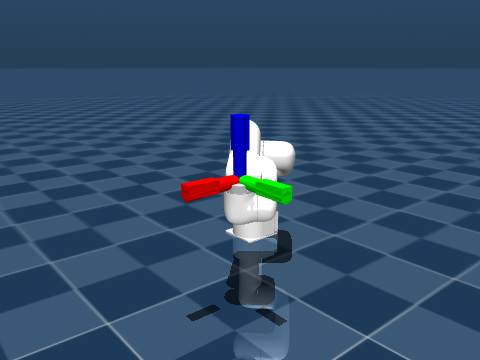

In [13]:
# Update and visualize
data.qpos = x_analytic
mujoco.mj_kinematics(model, data)
mujoco.mj_camlight(model, data)
camera.distance = 1
camera.lookat = data.site('attachment_site').xpos

# Disable the label visualisation
voption.label = mujoco.mjtLabel.mjLABEL_NONE
renderer.update_scene(data, camera, voption)

media.show_image(renderer.render())

Looks good! Let's move the arm to each of these waypoints by solving the inverse kinematics at each

In [14]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
x = x0
mujoco.mj_resetData(model, data)
data.qpos = x0

while data.time < DURATION:
  # Move the target
  pos, quat = spin_motion(data.time, speed=1)

  x_prev = x.copy()

  # Define IK problem
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                           reg_target=x_prev)

  x, _ = minimize.least_squares(x, ik_target, bounds,
                                jacobian=ik_jac,
                                verbose=0)
  data.ctrl = x
  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

## More utils

Let's abstract away this functionality into some useful helper functions before our code gets messy

In [30]:
def solve_ik(pos, quat, x0, radius=0.2, reg=0.1, reg_target=None):
  """
  Solve for an end effector pose, return joint angles
  Args:
    radius: weighting for quaternions when solving. Higher means more importance on getting orienation right.
    reg: weighting of regularisation term. Higher means more regularisation/stability, but less adaptable
  """
  if reg_target is None:
    reg_target = x0
  
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=reg_target, radius=radius, reg=reg)
  ik_jac_target = lambda x, res: ik_jac(x, res, radius=radius, reg=reg)
  
  x, _ = minimize.least_squares(x0, ik_target, bounds,
                              jacobian=ik_jac_target,
                              verbose=0)
  return x


def render_state(x, show=True):
  """
  Render arm position given joint angles, and optionally show the render
  """
  data.qpos = x

  mujoco.mj_kinematics(model, data)

  camera.lookat = data.site('attachment_site').xpos
  renderer.update_scene(data, camera, voption)
  pixels = renderer.render()
  if show:
    media.show_image(pixels)
  return pixels

def plot_pose(pos, quat, x0, show=True):
  """
  Solve for an end effector pose, render, and optionally show the render
  """
  x = solve_ik(pos, quat, x0)
  pixels = render_state(x, show=show)
  return x, pixels

## Spin the robot - via joint angles
Now let's spin the robot with the `arm.set_servo_angle` API call, leveraging our inverse kinematics solution. It should look identical to the previous run.


In [ ]:
arm.set_mode(mode=1)
time.sleep(1)

x0 = model.key('faceout').qpos
arm.set_servo_angle(angle=x0, speed=0.8, wait=True)

print("Ready")

DURATION = 10
RATE = 20

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

x_prev = x0
angles = []
start_time = time.time()
while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print publish rate every 0.5s
    if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = spin_motion(t, speed=0.5)
    x = solve_ik(pos, quat, x_prev)
    angles.append(x)
    
    arm.set_servo_angle(angle=x, wait=False)
    # render_state(x)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)

    tdiff.append(t - t_prev)
    t_prev = t
    x_prev = x.copy()
    

Issues with position control:
- Arm lags behind commands, can't keep up to speed, even with wait=False. The rate dramatically decreases a few seconds in to the trajectory.
- Starts to skip at the end of the trajectory, guessing that there's a queue of all the poses sent which overflows
- Has a stepwise motion which becomes fairly fine and unnoticeable at higher rates (200Hz) but it's still there and not as smooth as it could be


In [117]:
# Disable the arm
arm.motion_enable(False)

0

# Open loop velocity control

Time to get smooth motion with velocity commands!

This spin_motion_twist function is the derivative of the spin_motion one we were using above, i.e. it outputs a twist that produces the desired motion. We just have to start it from the right place and see how well it tracks. It is in world frame

In [16]:
def spin_motion_twist(time, speed=1):
  """
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the end effector facing outwards
  """

  vel = np.array([0.4 * np.cos(speed*time)*speed,
         -0.4 * np.sin(speed*time)*speed,
         0.1 * np.cos(3 * speed*time) * 3 * speed])
  # Angula velocity around z axis
  thetadot = -speed
  w = np.array([0, 0, thetadot])
  
  return vel, w

Let's check that it's correct by integrating it and visualising it with the target frame

In [23]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

mujoco.mj_resetDataKeyframe(model, data, model.key('faceout').id)
init_pos, init_quat = spin_motion(0)

site_id = model.site('attachment_site').id
target_id = model.body('target').mocapid

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat
mujoco.mj_forward(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  vel, w = spin_motion_twist(data.time)
  data.mocap_pos[id] += np.array(vel) * model.opt.timestep

  # angular velocity w is in the base frame, so we have to convert to target frame before integrating
  w_rot = np.zeros(3)
  init_quat_inv = np.array((init_quat[0], -init_quat[1], -init_quat[2], -init_quat[3]))
  mujoco.mju_rotVecQuat(w_rot, w, init_quat_inv)

  qdiff = np.zeros(4)
  qcurr = data.mocap_quat[id][0, :]
  mujoco.mju_quatIntegrate(qcurr, w_rot, model.opt.timestep)
  data.mocap_quat[target_id] = np.atleast_2d(qcurr)
  
  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

array([0], dtype=int32)

This next cell uses the `vc_set_cartesian_velocity` API call to do velocity control of the arm in task space (i.e. world frame).

The arm needs to be set to mode 5 - cartesian velocity control.

In [59]:
#  Helper function
def mujoco_to_xarm_twist(vel, w):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  vel_mm = np.array(vel)*1e3
  return list(vel_mm) + list(w)

In [252]:
# Move the arm to start position
arm.set_mode(mode=1)
arm.set_state(state=0)
time.sleep(1)

x0 = model.key('faceout').qpos
arm.set_servo_angle(angle=x0, speed=10, wait=True)

# Switch to velocity control
arm.set_mode(5)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 30
RATE = 10 

t = 0
timing_print_interval = 0.5
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

x_prev = x0
start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate at intervals
  if (len(tdiff) > 0) and int(t/timing_print_interval) != int(t_prev/timing_print_interval):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  vel, w = spin_motion_twist(t, speed=0.6)
    
  arm.vc_set_cartesian_velocity(speeds=mujoco_to_xarm_twist(vel, w), duration=0.5)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)
  x_prev = x.copy()

ready
Rate: 12.195388883752114
Rate: 9.625690146844248
Rate: 9.674107239647219
Rate: 9.423661516906314
Rate: 9.648803487856364
Rate: 9.629831671538632
Rate: 9.518391585571038
Rate: 9.609855321902238
Rate: 9.683389504003516
Rate: 9.673861800656317
Rate: 9.59079935370838
Rate: 9.60671661003222
Rate: 9.51900940484404
Rate: 9.684811557017332
Rate: 9.76209583569959
Rate: 9.544774125660565
Rate: 9.525637642300758
Rate: 9.583261170864429
Rate: 9.65922495059045
Rate: 9.691462288063729
Exiting, error 22


In [154]:
# In case of errors
arm.clean_error()

0

### Velocity control with IK
From before
```
r = J(theta)
```
We can differentiate the end effector position r via the chain rule to get v, the end effector velocity:
```
v = J(theta)*thetadot
```
Thus for a desired v at current joint angle theta, we can find the required joint velocities:
```
thetadot = J(theta)^-1*v
```
Because J(theta) is a linearised approximation at the given angle theta, the further our joint angles really are from theta, the worse the approximation and the worse the solution. So it's important to get the intial conditions right!

One shortcut we are taking in the simulation here for simplicity is that we're setting the velocities of the joints directly with data.qvel. We could create velocity actuators for the joints in the model XML and specify their gains, for modelling of the arm's motors, but it works well enough here to just assume the joints will directly reach the velocity set.

For simplicity, I've used np.linalg.solve, which solves the equation if J is full rank, as it is through this manoeuvre. But it will fail at singularities or if the arm is fully outstretched - ways around this are discussed later.

In [24]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution

DURATION = 10          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
x0 = model.key('faceout').qpos
data.qpos = x0

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.empty((6, model.nv))
twist = np.empty(6)

while data.time < DURATION:
  
  twist[:3], twist[3:] = spin_motion_twist(data.time, speed=1)
  
  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  # Solve system of equations: J @ qdot = v
  # This will fail at singularities
  data.qvel = np.linalg.solve(jac, twist)

  # Move the target
  pos, quat = spin_motion(data.time, speed=1)
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

Uh oh, it's veering off course. Because there is no closed-loop control here, the errors eventually accumulate and cause the arm to go off course. We will soon add this control loop in, but for now, let's see if we can make the path more accurate by reducing the timestep of the simulation, reducing the error in approximation of theta. The downside is of course, that the simulation takes much longer to run.

In [81]:
# Default is 0.002s, let's go to 0.0001
model.opt.timestep = 5e-5

DURATION = 10          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
x0 = model.key('faceout').qpos
data.qpos = x0

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.empty((6, model.nv))
twist = np.empty(6)

while data.time < DURATION:
  
  twist[:3], twist[3:] = spin_motion_twist(data.time, speed=1)

  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  data.qvel = np.linalg.solve(jac, twist)

  # Move the target
  pos, quat = spin_motion(data.time, speed=1)
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

Much nicer. Let's run it on the robot!

I found that the robot is able to do a full rotation or two at an update rate as low as 5Hz with the speed below 1 before it starts to veer significantly off track. Things only get better and smoother higher rates like 50Hz. I couldn't notice any difference between 50 and 200Hz at this speed.


At high speed (~1.5) things get a bit less stable, even at 200Hz.

See what works for you!

In [537]:
arm.motion_enable(enable=True)
arm.set_mode(1)
arm.set_state(state=0)
time.sleep(1)

x0 = model.key('faceout').qpos
data.qpos = x0
arm.set_servo_angle(angle=x0, speed=0.5, wait=True)

arm.set_mode(4)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 25
RATE = 200

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

speed = 1.5

jac = np.empty((6, model.nv))
twist = np.empty(6)


start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate every 0.5s
  if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  twist[:3], twist[3:] = spin_motion_twist(t, speed=speed)

  # Set current position in mujoco model
  code, state = arm.get_servo_angle()
  data.qpos = np.array(state[:6])
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data)

  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  qvel = np.linalg.solve(jac, twist)
  data.qvel = qvel
    
  arm.vc_set_joint_velocity(speeds=list(qvel), duration=0.5)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)


ready
Rate: 170.48312244256792
Rate: 167.11486381763248
Rate: 168.16013907286893
Rate: 168.6039846185139
Rate: 169.74589739656832
Rate: 169.45245049914956
Rate: 166.7731222882445
Rate: 165.79593872872903
Rate: 169.06080911137053
Rate: 167.2394688438386
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7125702179468907, 0.27805073023993576, -0.13882175288229912, -0.029633127792818646, 0.4534023296806626, -0.08733751064760592, 0], is_sync=True
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7138646903030677, 0.2426556088877383, -0.1365713691286156, -0.08239991494628654, 0.420371556358703, -0.03220033876294871, 0], is_sync=True
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7150539924256336, 0.20591445894377805, -0.13404845860412978, -0.13700023186473934, 0.3858585245285764, 0.024936578713805158, 0], is_sync=True
[SDK][ERROR][2024

## Closed loop velocity control

Let's use our velocity control but with feedback so we can stick to the target. Our very simple position controller calculates the error between the current pose and the desired pose, and this error becomes the velocity output,  pushing the arm towards the desired pose.

From our previous equations, we know the relationship between the end effector velocities
```
v = J(theta)thetadot
```
This allows us to approximate a small change in theta (dq) from a small change in end effector position (dr)
```
dr = J(theta) dq
```
dr is our error term - the difference between our current and desired position
```
err = J(theta) * dq
dq = J(theta)^-1 * err
```

We can solve this in a couple of ways: 
#### Solve for next position
Because we can already iteratively find an IK solution for any valid position, we can just solve for the desired position and subtract the solution from the current angle
```
theta' = J^-1 * r'
dq = theta' - theta
```
This is the slowest method because we're recomputing J for each step of the iterative optimisation, but it is of course robust to large changes in position.

#### Solve for the error directly
If the angle changes are small, we can skip the iterative optimisation step and solve more quickly
```
err = r' - r
dq = J(theta)^-1 * err
```

### Computing the solution
As noted previously, [np.linalg.solve](https://numpy.org/devdocs/reference/generated/numpy.linalg.solve.html) will find an exact solution when J is square and full rank. However, this is not always the case. For example, a 7-DOF robot has an extra degree of freedom, its Jacobian is 6x7 - there are usually multiple solutions. Thus a least squares solution like the pseudoinverse is instead used, which will find a best solution given the constraints. Our robot arm here is 6DOF so we can get away with using np.linalg.solve, but in cases where it is rank deficient, it may return nonsensical solutions.

The arm can also encounter singularities, where robot joints align in ways that causes it to lose a degree of freedom, or they reach their limits, so there is no possible solution for some end effector movements. In this case, it becomes rank deficient, so np.linalg.solve will fail/return nonsensical solutions.

Near singularities, the pseudoinverse will also start to become numerically unstable - think of it like dividing by numbers close to zero. Certain joints will require unreasonably high velocities, which can cause oscillations and erratic movements. If it is _exactly_ at a singularity, it will find a least squares solution in a well behaved way, but this is of course never the case in the real world so not really worth considering.

There are two common ways to deal with this:

#### Nullspace method
This method adds second objectives to the solution without interfering with the primary objective of finding the joint angles/velocities. That is, instead of just solving for joint angles, we can also exploit any freedom in the system to satisfy some other objective without affecting the end effector movement. For example, certain movements may only require 5 DOF on our 6 DOF robot arm, so instead of arbitrarily choosing one of the many solutions, we can choose a solution that advances a secondary objective.

One such useful secondary objective is to avoid singularities. This can be done by maximising the determinant (singularities occur when the determinant is 0), or by mimicking (minimising the difference in joint angles to) a reference pose which is known to not be singular.

Another useful objective is for obstacle avoidance, i.e. we move the end effector through a required path (assumed to be possible) whilst contorting the rest of the arm to avoid obstacles that may get between it and the end effector but don't lie on the path.

#### Damping
Adding a small constant to the diagonal of the matrix reduces the blow-up of joint velocities near singularities, at a minor accuracy cost. Think of it like instead of dividing zero, we are dividing by a small number that will reduce the blow-up by orders of magnitude, but will be insignificant the further away we are from singularity. This is called a damping constant, and it reduces erratic movements and oscillations near singularities. It is equivalent to the Levenberg-Marquardt optimisation solution.


More detail on both can be found here: https://www.cs.cmu.edu/~15464-s13/lectures/lecture6/iksurvey.pdf

### Solvers
We have a few solvers to choose from. Here's a run down:
- np.linalg.solve
  - easy to use and fast but only for square, full rank matrices
  - LAPACK-accelerated
- mujoco.minimize.least_squares: least squares solver with box bounds
  - least squares is robust to over or underconstrained problems
  - optimised for small matrices as found in these kinds of problems
  - box bounds allow solving only within joint limits of robot
  - can use analytic jacobians for speed-up
  - LM regularisation inherently adds damping

I played around with a few of the different solutions here. These are the times they took to do the 5s trajectory (5/0.002 = 2500 steps):
1.  solving for next pose - 0.77s
2.  solve dq - np.linalg.solve - 0.038s
3.  solve dq - mujoco least squares - 0.20s
4.  solve dq - np.linalg.solve + damping - 0.045s

Obviously these measurements are not a rigorous comparison but give you a good idea of the order of magnitude in solving time.


In [42]:
model.opt.timestep = 0.002

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
x0 = model.key('faceout').qpos
data.qpos = x0
x_prev = x0

init_pos, init_quat = spin_motion(0, speed=1)
data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.zeros((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)
# Damping coefficient for method 4
damp = 1e-4 * np.eye(6)

import time
soln_time = 0

while data.time < DURATION:
  
  target_pos, target_quat = spin_motion(data.time, speed=1)

  method = 4
  t1 = time.perf_counter()

  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq

    x = solve_ik(target_pos, target_quat, x_prev)
    dq = x - data.qpos

  else:
    # Solving directly for dq

    # Calculate error term and jacobian
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)

    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      # Undamped least squares
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation, equivalent to damping
      # J(theta) * dq - err = 0
      res = lambda x: jac @ x - error.reshape(-1, 1)
      dq, _ = minimize.least_squares(x - x_prev, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + damp, error)

  t2 = time.perf_counter()

  soln_time += t2 - t1

  data.qvel = dq
  
  # Move the target
  data.mocap_pos[target_id] = target_pos
  data.mocap_quat[target_id] = target_quat

  mujoco.mj_step(model, data)

  x_prev = data.qpos.copy()

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

print(f"Spent {soln_time:.4f}s ({soln_time / DURATION * model.opt.timestep:.4E} per step) solving with method {method}")


Spent 0.0482s (1.9279E-05 per step) solving with method 4


## Gain term
The arm follows the path but is clearly lagging. We've forgotten to apply the velocity _over_ the timestep - in other words, we want to make up that distance by the time we reach the next control loop. This means dividing by the control period, which in this case is the timestep of the simulation (0.002s by default), giving us a value in metres per second in task space or radians per second in state space.
```
v = dq/dt
```
In practice, this actually makes the arm unstable and liable to overshoot the solution (remember, our dq is only approximate), so we reduce it by a gain term Kp between (0, 1).  Kp = 0.5 means that the robot is trying to cut the error in half each timestep. I've found anywhere from 0.1-0.5 to work pretty well in the simulation. More here: https://scaron.info/robotics/differential-inverse-kinematics.html#task-gains

```
v = Kp*dq/dt
```

In [68]:
model.opt.timestep = 0.002

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
x0 = model.key('faceout').qpos
data.qpos = x0
x_prev = x0

init_pos, init_quat = spin_motion(0)
data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.zeros((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)

Kp = 0.5

import time
soln_time = 0

while data.time < DURATION:
  
  target_pos, target_quat = spin_motion(data.time, speed=1)

  method = 3

  t1 = time.perf_counter()
  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq
    x = solve_ik(target_pos, target_quat, reg_target=x_prev)
    dq = x - data.qpos

  else:
    # Solving directly for dq

    # Calculate error term and jacobian
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)

    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation
      res = lambda x: jac @ x - error.reshape(-1, 1)
      dq, _ = minimize.least_squares(x - x_prev, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Damping coefficient
      diag = 1e-4 * np.eye(6)
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)

  t2 = time.perf_counter()

  soln_time += t2 - t1

  # We could use qvel and integrate here
  # data.qpos += dq
  data.qvel = Kp*dq/model.opt.timestep
  
  # Move the target
  data.mocap_pos[target_id] = target_pos
  data.mocap_quat[target_id] = target_quat

  mujoco.mj_step(model, data)

  x_prev = data.qpos.copy()

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

print(f"Spent {soln_time:.4f}s ({soln_time / DURATION * model.opt.timestep:.4E} per step) solving with method {method}")


Spent 0.1907s (7.6281E-05 per step) solving with method 3


### P controller on the robot
Let's run it on the robot. To avoid erratic motion, let's start with a conservative Kp value of 0.02 and gradually increase.
Anywhere from 0.04-0.1 seem to work fairly nicely.

There's a very sudden start from rest which is quite jarring, due to the discontinuity in velocity (from rest instantly to speed). A gradual speed up would help.

In [669]:
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)


x0 = model.key('faceout').qpos
arm.set_servo_angle(angle=x0, speed=0.8, wait=True)

arm.set_mode(4)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 25
RATE = 200

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

speed = 1.2

code, state = arm.get_servo_angle()
if state[0] < 0:
  print("flip")
  speed = -speed

jac = np.empty((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)

Kp = 0.02

start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate every 0.5s
  if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  target_pos, target_quat = spin_motion(t, speed=speed)

  # Set current position in mujoco model
  code, state = arm.get_servo_angle()
  xcurr = np.array(state[:6])
  
  # Solve for J @ dq = error
  method = 3

  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq
    x = solve_ik(target_pos, target_quat, reg_target=xcurr)
    if any(np.isclose(x[0:1], bounds[0][0:1], atol=0.05)) or any(np.isclose(x[0:1], bounds[1][0:1], atol=0.05)):
      print("Aiming past limits, break")
      break

    dq = x - xcurr

  else:
    # Solving directly for dq
    # Calculate error term and jacobian
    data.qpos = xcurr
    mujoco.mj_kinematics(model, data)
    mujoco.mj_comPos(model, data)
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)
    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation
      res = lambda x: jac @ x - error.reshape(-1, 1)
      ## TODO: 
      dq, _ = minimize.least_squares(dq, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Damping coefficient
      diag = 1e-4 * np.eye(6)
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)
    
    
  arm.vc_set_joint_velocity(speeds=list(Kp*dq*RATE), duration=0.1)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)


[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move


ready
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.2706152163098214, 0.04856679095083255, 0.389449304571291, 0.0009571225350684813, -0.33283667013228113, -0.0012411461965024003, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.4006653722787064, 0.030127346536724504, 0.37934914822309124, 0.0010782057474757148, -0.3411768841557815, -0.0013832672310246314, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.5391273194751465, 0.0077293615942300485, 0.36131839673057325, 0.0015159985573560467, -0.3455452008530862, -0.001833590507809341, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.6799177149279865, -0.017976355874946198, 0.335268683586224, 0.002319419521214127, -0.3452024133854038, -0.0026382542771274213, 0], is_sync=True
[SDK][

[SDK][ERROR][2024-06-19 12:15:07][base.py:168] - - [report-socket] socket read timeout


# Getting between two points - Screw trajectory
The simplest way to get from one pose to the other is in a straight line. This involves interpolating between two quaternions to get smoothly from one orientation to the other, whilst simultanesouly interpolate the position linearly, and have your robot at the right pose. That's simple enough that I'll skip demonstrating here.

The next step up is to interpolate position and orientation simultaneously via a screw trajectory, which applies a constant twist (linear and angular velocity combined) to get from the start to the end pose, coupling the rotation and translation. This creates an arc like motion, following a certain radius, that has less of a tendency to go straight through the centre of the robot and self intersect if going from one side to the other. But it is just as dumb, there is no collision detection involved.

For a primer on the theory, watch/read the [chapter](https://modernrobotics.northwestern.edu/nu-gm-book-resource/9-1-and-9-2-point-to-point-trajectories-part-1-of-2/#department) on trajectory generation from the Modern Robotics textbook by Kevin Lynch, and Frank Park

### Time scaling
A time scaling _s(t)_ maps a path (a curve to be followed) to a trajectory (a path/poses as a function of time). A short time obviously means that the robot is moves at higher velocity.

A linear time scaling would result in jerky motion at the start and end as the robot would have to instantaneously jump to the initial velocity. Instead, a third order polynomial allows us to ramp the velocity up and down and the start and end smoothly if we pick appropriate coefficients. A 5th order polynomial allows for a smooth ramp of acceleration as well. 

_s(t)_ is in the range [0, 1]

In [70]:
def s(t, end_time):
  """
  Calculate a third order polynomial time scaling s
  s = a0 + a1*t + a2*t^2 + a3*t^3
  where
  s = 0 at t=0 and s=end_time at t=end_time
  sdot is 0 at t=0 and t=end_time

  Vectorised implementation allows calculation of multiple t values simultaneously

  Args:
    t: a time or array of times for which to calculate s
    end_time: the duration of the trajectory, shorter means faster

  Returns:
    s: s value
    s_1: first derivative of s
    s_2: second derivative of s
  """
  t = np.array(t)
  assert(np.all(t >= 0) and np.all(t <= end_time))
  a0 = 0
  a1 = 0
  a2 = 3/end_time**2
  a3 = -2/end_time**3

  # Constants for s, sdot, sddot
  A = np.array([[a0, a1, a2, a3],
                [a1, 2*a2, 3*a3, 0],
                [2*a2, 6*a3, 0, 0]])

  # Form a matrix of
  # [1,     1,     ...]
  # [t0,    t1,    ...]
  # [t0**2, t1**2, ...]
  # [t0**3, t1**3, ...]
  x = np.ones(t.size)
  for i in range(1, 4):
      x = np.vstack((x, t**i))

  assert(x.shape == (4, t.size))

  s = A @ x
  s_0 = s[0, :]
  s_1 = s[1, :]
  s_2 = s[2, :]
  return s_0, s_1, s_2


Now let's plot the time scaling so you can see its properties

Text(0.5, 1.0, 'sddot')

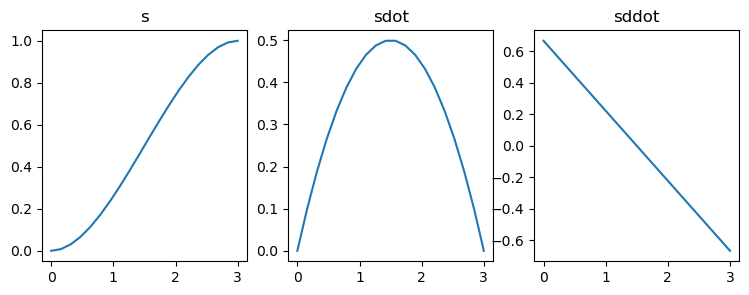

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

end_time = 3
t = np.linspace(0, end_time, 20)

s_0, s_1, s_2 = s(t, end_time)

fig = plt.figure(figsize=(9, 3))
ax = plt.subplot(1, 3, 1)
ax.plot(t,s_0)
ax.set_title("s")

ax = plt.subplot(1, 3, 2)
ax.plot(t,s_1)
ax.set_title("sdot")

ax = plt.subplot(1, 3, 3)
ax.plot(t,s_2)
ax.set_title("sddot")


Notice the parabolic sdot (velocity) curve starting and ending at rest. Whereas the acceleration (s double dot) is discontinuous at start and end - which is fine, but if you want the acceleration to smoothly ramp, try a 5th order polynomial.

The next cell defines some functions for turning position and orientation into a homogeneous transform matrix for doing pose interpolation.

In [72]:
def get_tf_matrix(pos, quat):
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  pos = np.reshape(np.atleast_2d(pos), (3, 1))
  R = np.zeros(9)
  mujoco.mju_quat2Mat(R, quat)
  R = np.reshape(R, (3, 3))
  T = np.hstack((R, pos))
  T = np.vstack((T, [0, 0, 0, 1]))
  return T

def tf_matrix_to_pose_quat(T):
  R = T[:3, :3].reshape((9, 1))
  pos = list(T[:3, 3])
  quat = np.zeros(4)
  mujoco.mju_mat2Quat(quat, R)
  return pos, quat

def invert_tf_matrix(T):
  R = T[:3, :3]
  t = T[:3, 3]
  T_inv = np.eye(4)
  T_inv[:3, :3] = R.T
  T_inv[:3, 3] = -R.T @ t
  
  return T_inv


Tinit = get_tf_matrix(np.array([0.1, 0.1, 0.1]), np.array([0.5, 0.5, -0.5, 0.5]))
Tinit_inv = invert_tf_matrix(Tinit)
Tinit_recomp = invert_tf_matrix(Tinit_inv)
print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")

assert(np.allclose(Tinit, Tinit_recomp))

pos, quat = tf_matrix_to_pose_quat(Tinit)
Tinit_recomp = get_tf_matrix(pos, quat)

print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")
assert(np.allclose(Tinit, Tinit_recomp))


Tinit:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit_recomp:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit_recomp:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]


Here is our screw interpolation function, which calculates the desired pose at each time

In [76]:
from scipy.linalg import logm, expm
def screw_interp(T_start, T_end, t, end_time):
  """ 
  Screw interpolation calculates a constant twist to get from the start pose to the end pose in the given time.
  This function calculates the pose at a given time t along the trajectory, using our time scaling s(t) from before.
  Args:
    T_start: start pose, as a 4x4 transform matrix
    T_end: end pose, as a 4x4 transform matrix
    t: the time at which to s
  """
  assert(t >= 0 and t <= end_time)
  return T_start @ expm(logm(invert_tf_matrix(T_start)@T_end)*s(t, end_time)[0])

# Tests
# TODO: set test values
q = np.random.rand(4) - 0.5
q /= np.linalg.norm(q)
Tnext = get_tf_matrix(np.random.rand(3), q)
assert(np.allclose(screw_interp(Tinit, Tnext, 0, 3), Tinit))

print(f"End interp:\n{screw_interp(Tinit, Tnext, 3, 3)}\nEnd pose:\n{Tnext}")
# np.isclose(screw_interp(Tinit, Tnext, 3, 3), Tnext)
assert(np.allclose(screw_interp(Tinit, Tnext, 3, 3), Tnext))
    

End interp:
[[-0.4844 -0.8588 -0.167   0.6365]
 [-0.6253  0.2063  0.7526  0.0511]
 [-0.6119  0.469  -0.6369  0.0068]
 [ 0.      0.      0.      1.    ]]
End pose:
[[-0.4844 -0.8588 -0.167   0.6365]
 [-0.6253  0.2063  0.7526  0.0511]
 [-0.6119  0.469  -0.6369  0.0068]
 [ 0.      0.      0.      1.    ]]


Visualise the interpolated poses in Mujoco to see how the trajectory will look. For this one, we'll get it to plan a trajectory from the current robot position to the next. If you're not connected to an arm, use the commented code instead

Interpolation:
[[ 0.   -1.    0.    0.  ]
 [ 0.    0.    1.    0.4 ]
 [-1.    0.    0.    0.35]
 [ 0.    0.    0.    1.  ]]
[[ 0.     -0.9965  0.0839  0.0336]
 [ 0.      0.0839  0.9965  0.3986]
 [-1.      0.      0.      0.3512]
 [ 0.      0.      0.      1.    ]]
[[ 0.     -0.9517  0.307   0.1228]
 [ 0.      0.307   0.9517  0.3807]
 [-1.      0.      0.      0.3543]
 [ 0.      0.      0.      1.    ]]
[[ 0.     -0.7973  0.6036  0.2414]
 [ 0.      0.6036  0.7973  0.3189]
 [-1.      0.      0.      0.3589]
 [ 0.      0.      0.      1.    ]]
[[ 0.     -0.4924  0.8704  0.3482]
 [ 0.      0.8704  0.4924  0.1969]
 [-1.      0.      0.      0.3645]
 [ 0.      0.      0.      1.    ]]
[[ 0.     -0.0707  0.9975  0.399 ]
 [ 0.      0.9975  0.0707  0.0283]
 [-1.      0.      0.      0.3706]
 [ 0.      0.      0.      1.    ]]
[[ 0.      0.3646  0.9312  0.3725]
 [ 0.      0.9312 -0.3646 -0.1458]
 [-1.      0.      0.      0.3767]
 [ 0.      0.      0.      1.    ]]
[[ 0.      0.7041  0.7101  0.2


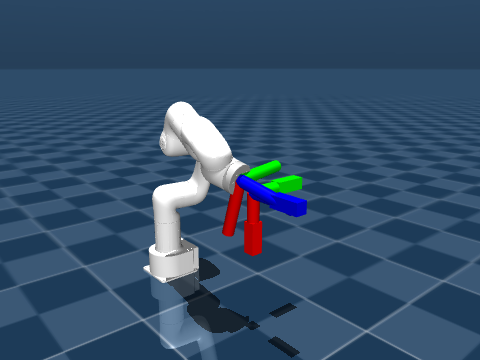
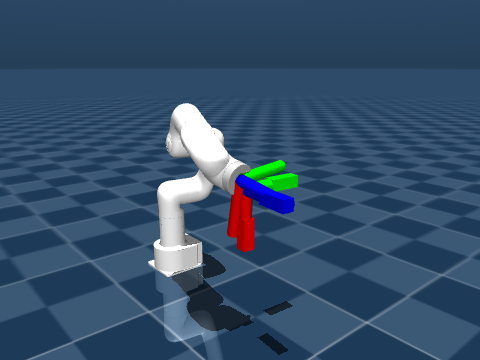
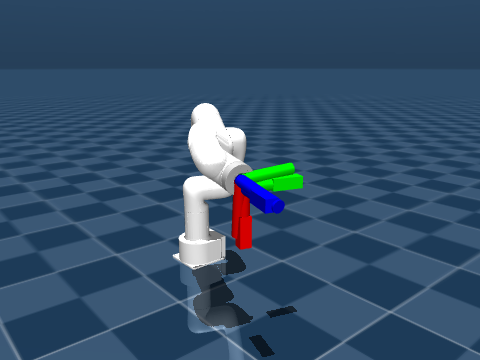
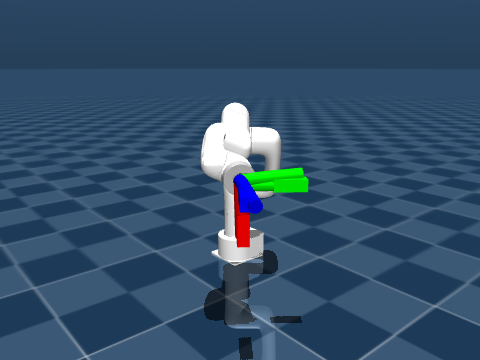
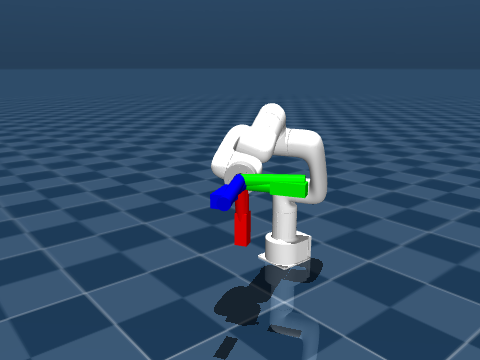
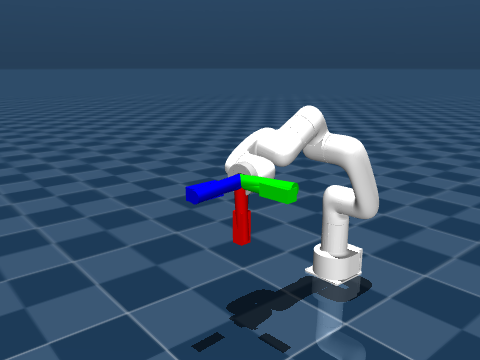
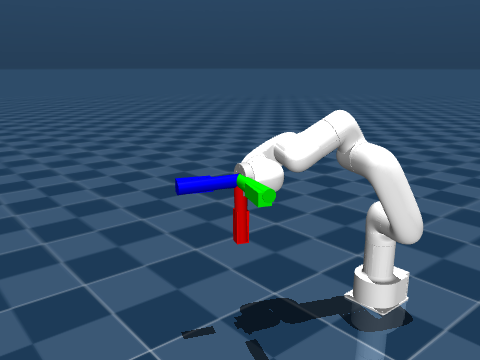
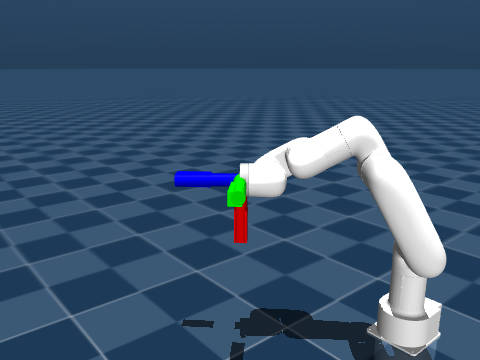
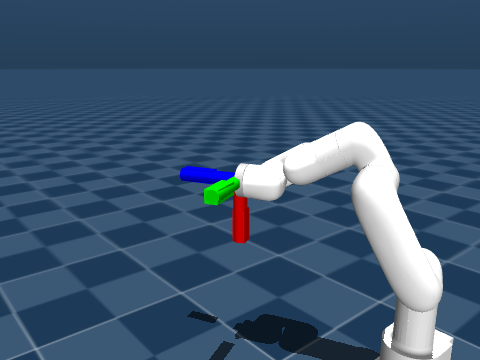
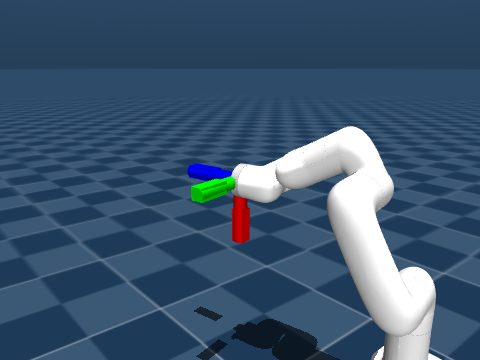
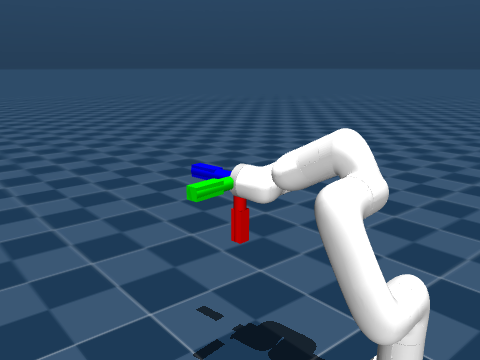

In [93]:
# Get the current arm position
arm = XArmAPI(ip, is_radian=True)
curr_pos, curr_quat = xarm_to_mujoco_pose(arm.get_position_aa()[1])
T1 = get_tf_matrix(curr_pos, curr_quat)

# If you're not connected to an arm, use this dummy position instead
# x0 = solve_ik(*spin_motion(0), x0=np.zeros(6))
# data.qpos = x0
# mujoco.mj_forward(model, data)
# T1 = get_tf_matrix(*spin_motion(3))

T2 = get_tf_matrix(*spin_motion(0))
screw_waypoints = [screw_interp(T1, T2, t, end_time) for t in np.linspace(0, end_time, 11)]

print("Interpolation:")
[print(T) for T in screw_waypoints]
print("T1:")
print(T1)
frames = []
xprev = x0
for T in screw_waypoints:
  xprev, pixels = plot_pose(*tf_matrix_to_pose_quat(T), xprev, show=False)
  frames.append(pixels)

media.show_images(frames)
media.show_video(frames, loop=False, fps=len(frames)/end_time)


Now let's run one on the robot! This takes it from its current position to the start position of the spin trajectory

In [ ]:
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)
print("ready")

curr_pos, curr_quat = xarm_to_mujoco_pose(arm.get_position_aa()[1])
Tcurr = get_tf_matrix(curr_pos, curr_quat)
Tinit = get_tf_matrix(*spin_motion(0))

end_time = 3

screw_waypoints = [screw_interp(Tcurr, Tinit, t, end_time) for t in np.linspace(0, end_time, 11)]

for T in screw_waypoints:
  # time.sleep(1)
  next_pose = mujoco_to_xarm_pose(*tf_matrix_to_pose_quat(T))
  print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
  arm.set_position_aa(next_pose, speed=200, radius=None, wait=True)

ready
Move from [-64.819702, -316.95401, 325.143066, 1.36205, 1.172681, -1.220693] to [-64.819702, -316.95401, 325.143066, 1.3620500000000002, 1.172681, -1.220693] 
Move from [-64.819702, -316.95401, 325.143066, 1.36205, 1.172681, -1.220693] to [-94.89891107458665, -311.24324175599213, 324.60880714336605, 1.4243330881913514, 1.1281901474965903, -1.2819838499380067] 
Move from [-94.898911, -311.243256, 324.608795, 1.424333, 1.12819, -1.281984] to [-172.95507642445568, -283.1715993838025, 323.6784857584922, 1.5897620206736398, 0.9945295212048961, -1.4456411259967206] 
Move from [-172.955078, -283.1716, 323.678497, 1.589762, 0.99453, -1.445641] to [-271.47396852122534, -211.3261914017058, 323.7465801301031, 1.8219451102260855, 0.76138816257288, -1.6778776563451652] 
Move from [-271.473969, -211.326187, 323.746582, 1.821945, 0.761388, -1.677878] to [-350.546202649479, -86.56839190878152, 326.0639733123418, 2.0794296787098463, 0.415268627589546, -1.9403052238925274] 
Move from [-350.546204,